<h1><center>Modeling Neutronic Transient using Gaussian Processes</center></h1>
<h2><center>Statisitcs-713 Project</center></h2>

 <h3><center> by Rabab Elzohery</center></h3>


### Necessary Imports


In [238]:
# Imports 
import matplotlib.pylab as plt
%matplotlib inline
import plot_setting
import numpy as np
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# sikit-learn imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, Matern, RationalQuadratic


# Case study 1
This test case represents a simple 1D neutronic transeint. Coupling between different physics is not accounted for.


### Load the data and define some problem specific data


In [281]:
snapshots = np.loadtxt('../data/transient_sanpshots_UQ.txt')
flux = snapshots[:, :700].T
tf = 62 # final time
dt = 0.1 # time step
times = np.arange(0, tf+dt, dt)
Ncells = 350

## compute core power from flux
def power(flux):
    nufiss = np.array([[0.000, 0.003, 0.003, 0.003, 0.003, 0.003, 0.000],
                  [0.000, 0.19, 0.19, 0.19, 0.19, 0.19, 0.000]])

    fiss = np.repeat(nufiss, 50, axis=1)/2.5
    power = E*np.sum(fiss[0]* flux.T[:, :Ncells] + fiss[1]* flux.T[:, Ncells:], axis=1)
    
    return power

power_true = power(flux)
flux.shape

(700, 621)

### plot  the data

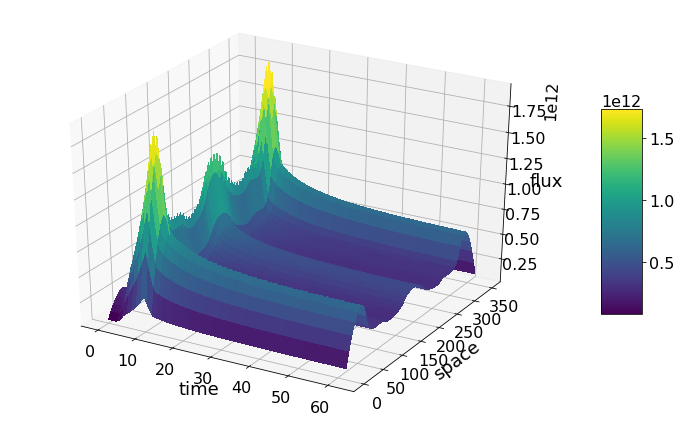

In [282]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
X = times
Y = range(Ncells)
Z = flux[Ncells:, :]
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.set_xlabel('time')
ax.set_ylabel('space')
ax.set_zlabel('flux')


surf = ax.plot_surface(X, Y, Z, cmap='viridis',linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Spatail averaged flux

Text(0, 0.5, 'Flux')

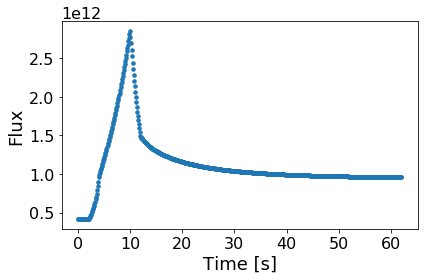

In [283]:
plt.plot(times, np.mean(flux, axis=0), '.')
plt.xlabel('Time [s]')
plt.ylabel('Flux')

### Potential for Reduction
A sinuglar value decomposition is performed to explore the potential of data for reduction

Text(0, 0.5, 'singular values')

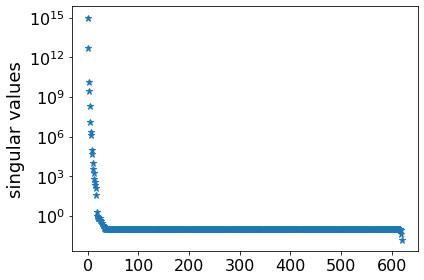

In [284]:
U, S, V = np.linalg.svd(flux)
plt.semilogy(S, '*')
plt.ylabel('singular values')

### Plot data correlation

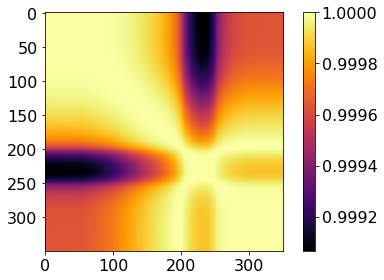

In [285]:
plt.imshow(np.corrcoef(flux[Ncells:, :]), cmap='inferno')
plt.colorbar()

### Reduction and Transformation

As in POD-gelerkin $\textbf{Y}(x,t)$  can be decomposed into spatail modes and time dependent amplitudes
$ \to \textbf{Y}  \approx \sum^r_i {\textbf{u}_i a_i(t)} = \textbf{U}\textbf{a} $

$\textbf{U}$ is computed from the SVD. Now, need to find $\textbf{a}(t)$!


#### Transformed Data 

$\textbf{a} = \textbf{U}^T_r Y_r^ = \boldsymbol{\Sigma}_r\textbf{V}_r^T$ 

Once $\textbf{a}$ is found, $\textbf{Y}$ can be computed $\to \textbf{Y} = \textbf{U}\textbf{a}$

### Plot the expansion coefficents $\textbf{a}(t)$

In [286]:
r = 20
Ur = U[:, :r]
a = Ur.T@flux

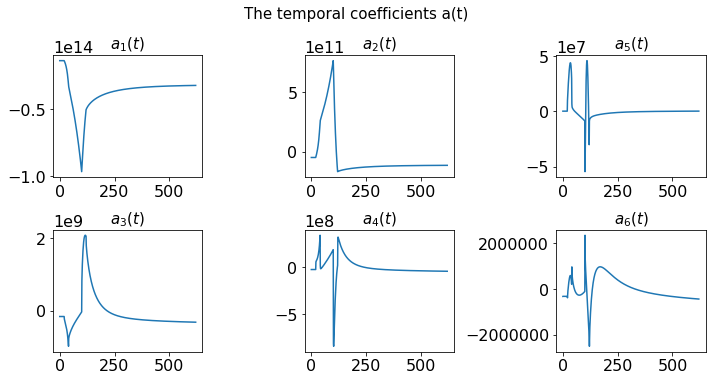

In [245]:
fig, axs = plt.subplots(2, 3, squeeze=False, figsize=(10,5))
fig.suptitle('The temporal coefficients a(t)', size=15, y=1.05)
axs[0, 0].plot(a[0, :])
axs[0, 0].set_title('$a_1(t)$',size = 15)

axs[0, 1].plot(a[1, :])
axs[0, 1].set_title('$a_2(t)$',size = 15)

axs[1, 0].plot(a[2, :])
axs[1, 0].set_title('$a_3(t)$',size = 15)

axs[1, 1].plot(a[3, :])
axs[1, 1].set_title('$a_4(t)$',size = 15)

axs[0, 2].plot(a[4, :])
axs[0, 2].set_title('$a_5(t)$',size = 15)

axs[1, 2].plot(a[5, :])
axs[1, 2].set_title('$a_6(t)$',size = 15)
fig.tight_layout() 


## Linear Models for $\textbf{a}(t)$

### Simple Linear Model / Constant variance model

Text(0, 0.5, 'absolute error')

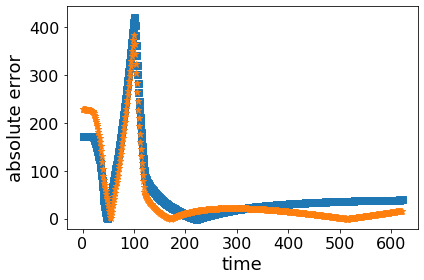

In [288]:
kernel = C(1, (0.01, 10.0))
from sklearn import linear_model

X = np.arange(0, 62.1, .1).reshape(-1, 1)
reg = linear_model.LinearRegression()
reg.fit(X, a.T)
a_predict = reg.predict(X)
y_approx = Ur@a_predict.T
power_predicted = power(y_approx)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, optimizer='fmin_l_bfgs_b')
gp.fit(X_train, a.T)
a_pred, sigma = gp.predict(X, return_std=True, return_cov=False)
y_approx_2 = Ur@a_pred.T

# compute predicted power
plt.plot(abs(power(y_approx_2) - power_true), 's')
plt.plot(abs(power_predicted - power_true), '*')
plt.xlabel('time')
plt.ylabel('absolute error')



### General Linear Model / Guassian Process

Assume a linear model with the following form:

$ Y \sim \mathcal{N} (\boldsymbol{\beta}, \textbf{K} + \sigma^2I)$

$\textbf{K}$ is called kernel or corelation functions. Different options can be used for $\textbf{K}$


### Guassian Processes model with different Kernels

Here, guassian processes model with different kernels is fitted

In [246]:
X = np.arange(0, 62.1, 0.1).reshape(-1, 1)
kernel_1 = C(1, (0.01, 10.0))
kernel_2 = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
kernel_3 = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
kernel_4 = 1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0))
kernel_5 =  1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)

kernels = [kernel_1, kernel_2 ,kernel_3, kernel_4, kernel_5]

names = ['Constant', 'RBF', 'Marten', 'ExpSineSquared', 'RationalQuadratic']

a_predict = np.zeros(a.shape)
a_prior = np.zeros(a.shape)
a_sigma = np.zeros(a.shape)
models = []
a_preds = []
for kernel in kernels:
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True, optimizer='fmin_l_bfgs_b')
    gp.fit(X, a.T)
    models.append(gp)
    a_pred, sigma = gp.predict(X, return_std=True, return_cov=False)
    a_preds.append(a_pred)

### Plot the residual

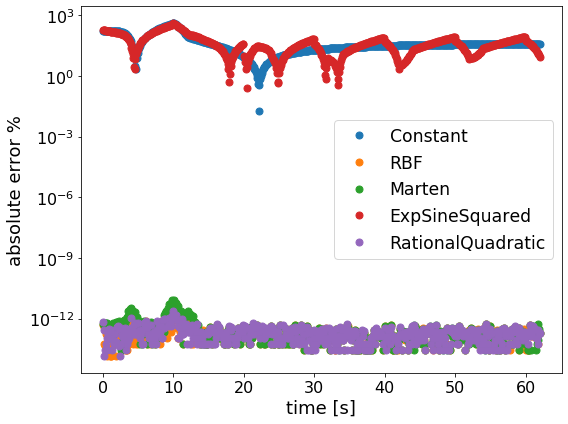

In [247]:
plt.figure(figsize=(8, 6))
for i in range(len(kernels)):
    flux_pred = Ur@a_preds[i].T
    power_pred_one_basis = power(flux_pred)
    errors_power_guassian_proc_one_basis = abs(power_true - power_pred_one_basis)
    plt.semilogy(times, errors_power_guassian_proc_one_basis.squeeze(), 'o')
    plt.xlabel('time [s]')
    plt.ylabel('absolute error %')
    plt.legend(names)

## Case Study 2:  Getting more complicated

The data studied here represent another transient experiment, i.e, the LRA Benchmark. Here, more complicated physics is accounted for in the simulation

### Load the data and define some problem specific data

In [248]:
import scipy as sp

kappa = 3.204e-11
LRA_data = pickle.load(open('../data/diffusion2x2_ref_with_mesh_temps.p', 'rb'), encoding='latin')
t = np.array(LRA_data['times'])   # time
mp = np.array(LRA_data['meshpower']).T # mesh-dependent powers
mp = mp * kappa
p = np.array(LRA_data['power'])# total power
c = p[0]/sp.sum(mp,axis=0)[0] # use to reconstruct power from mesh power
fuel_idx = mp[:, 0]>0                  # pick out fuel mesh
tmp_reduced = mp[fuel_idx, :] # extract fuel data
tmp_full = 0*mp[:, :]  # initialize full data

### Plot the data

Text(0, 0.5, 'power (W/cm$^3$)')

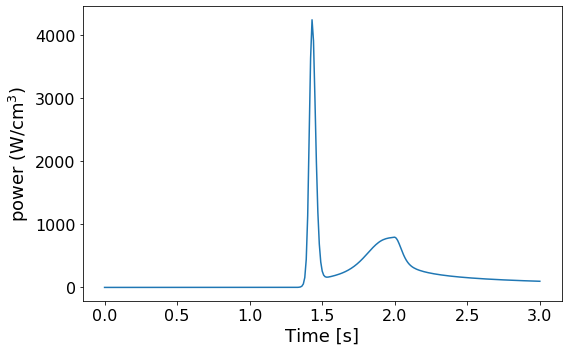

In [265]:
plt.figure(figsize=(8, 5))
plt.plot(t, p)
plt.xlabel('Time [s]')
plt.ylabel("power (W/cm$^3$)")

### Fit a general linear model
same as in the first case study

In [256]:
# compute temporal coefficient
U, S, V = np.linalg.svd(tmp_reduced)
r = 20
Ur = U[:, :r]

a = Ur.T@tmp_reduced
a_predict = np.zeros(a.shape)


errs  = []

for i in range(len(kernels)):
    gp = GaussianProcessRegressor(kernel=kernels[i], n_restarts_optimizer=9)
    X = t.reshape(-1, 1)
    y = a.copy()
    gp.fit(X, y.T)

    a_pred, sigma = gp.predict(X, return_std=True)
 
    tmp_reduced_pred = Ur@a_pred.T
    tmp_full[fuel_idx] = tmp_reduced_pred

    p_pred = c*sp.sum(tmp_full, axis=0)

    errs.append(abs(p - p_pred) *100)

### Plot the results

Text(0, 0.5, 'absolute error (%)')

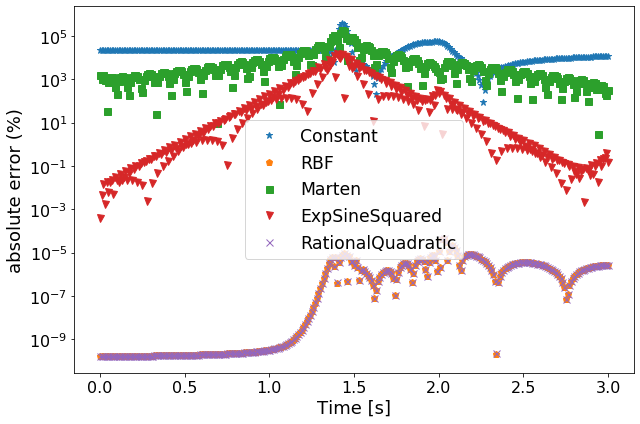

In [269]:
markers = ['*', 'p', 's', 'v', 'x']
fig = plt.figure(figsize=(9, 6))
for i in range(len(errs)):
   plt.semilogy(t, errs[i], markers[i])
plt.legend(names)
plt.xlabel('Time [s]')
plt.ylabel("absolute error (%)")